In [1]:
import math
import random
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [2]:

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR100('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR100('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)

indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)
print(len(train_loader),len(valid_loader))


/home/clayton/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/clayton/anaconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Files already downloaded and verified
Files already downloaded and verified
1250 313


In [3]:
#Standard CNN and NN
class Net(nn.Module):
  def __init__(self,**kwargs):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
    self.dropout=nn.Dropout(kwargs['dropout_rate'])
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(512 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 100)  # Output size should match the number of classes in CIFAR-100

  def forward(self, x):
      x = self.pool(nn.functional.relu(self.conv1(x)))
      x = self.pool(nn.functional.relu(self.conv2(self.dropout(x))))
      x = self.pool(nn.functional.relu(self.conv3(self.dropout(x))))
      x = (nn.functional.relu(self.conv4(self.dropout(x))))
      x = x.view(-1, 512 * 4 * 4)
      x = nn.functional.relu(self.fc1(self.dropout(x)))
      x = nn.functional.relu(self.fc2(self.dropout(x)))
      x = self.fc3(self.dropout(x))
      return x

In [4]:
#Sector-wise dropout layer
class SWDropOut(torch.nn.Module):
    def __init__(self,**kwargs):
        super().__init__()
        self.group_size = int(kwargs['group_size'])
        self.drop_per_group = int(kwargs['drop_per_group'])
        self.scalar = 1/((self.group_size-self.drop_per_group)/self.group_size)
     
    # def forward(self, x):
    #     if self.training:
    #         scalar_mask = torch.full(x.size(),self.scalar)
    #         batch,feature = x.size()
    #         for item in range(batch):
    #             for i in range(0,feature,self.group_size):
    #                 masked_count=0
    #                 while masked_count < self.drop_per_group:
    #                     index = random.randint(0, self.group_size-1) 
    #                     if scalar_mask[item][i+index] !=0:
    #                         scalar_mask[item][i+index]=0
    #                         masked_count+=1
    #         x = torch.multiply(x,scalar_mask)
    #         # print(x)
    #         return x
    #     else:
    #         return x
    def forward(self, x):
        if self.training:
            batch,feature = x.size()
            scalar_mask = torch.tensor([self.scalar for _ in range(feature)])
            for i in range(0,feature,self.group_size):
                masked_count=0
                while masked_count < self.drop_per_group:
                    index = random.randint(0, self.group_size-1) 
                    if scalar_mask[i+index] !=0:
                        scalar_mask[i+index]=0
                        masked_count+=1
            x = torch.multiply(x,scalar_mask)
            # print(x)
            del scalar_mask
            return x
        else:
            return x


In [23]:
#Sector-wise dropout layer
class SWDropOutConv(torch.nn.Module):
    def __init__(self,**kwargs):
        super().__init__()
        self.group_size = int(kwargs['group_size'])
        self.drop_per_group = int(kwargs['drop_per_group'])
        self.scalar = 1/((self.group_size-self.drop_per_group)/self.group_size)
     
    # def forward(self, x):
    #     if self.training:
    #         _,_,batch,feature = x.size()
    #         print(x.size()) #torch.Size([32, 64, 16, 16])
    #         scalar_mask = tensor.full(())
    #         scalar_mask = torch.tensor([self.scalar for _ in range(feature)])
    #         for i in range(0,feature,self.group_size):
    #             masked_count=0
    #             while masked_count < self.drop_per_group:
    #                 index = random.randint(0, self.group_size-1) 
    #                 if scalar_mask[i+index] !=0:
    #                     scalar_mask[i+index]=0
    #                     masked_count+=1
    #         x = torch.multiply(x,scalar_mask)
    #         # print(x)
    #         del scalar_mask
    #         return x
    #     else:
    #         return x
    # def forward(self, x):
    #     if self.training:
    #         _,a,b,c = x.size()
    #         # print(x.size()) #torch.Size([32, 64, 16, 16])
    #         scalar_mask = torch.full((a,b,c), self.scalar)
    # 
    #         for i in range(a):
    #             for j in range(b):
    #                 for k in range(0,c,self.group_size):
    #                     masked_count=0
    #                     while masked_count < self.drop_per_group:
    #                         index = random.randint(0, self.group_size-1) 
    #                         if scalar_mask[i][j][k+index] !=0:
    #                             scalar_mask[i][j][k+index]=0
    #                             masked_count+=1
    #         x = torch.multiply(x,scalar_mask)
    #         del scalar_mask
    #         del a,b,c
    #         return x
    #     else:
    #         return x
    def forward(self, x):
        if self.training:
            _,a,b,c = x.size()
            # print(x.size()) #torch.Size([32, 64, 16, 16])
            # scalar_mask = torch.full((2,(a*b*c)//2,), self.scalar)
            dim = int(math.sqrt(self.group_size))
            if self.group_size-self.drop_per_group==1:
                scalar_mask = torch.zeros((a,b,c))
                for i in range(a):
                    for j in range(0,b,dim):
                        for k in range(0,c,dim):
                            val = random.randint(0,self.group_size-1)
                            scalar_mask[i][j+(val%dim)][k+(val//dim)]=self.scalar
                # print(scalar_mask)
                x = torch.multiply(x,scalar_mask)
            else:  
                scalar_mask = torch.full((a,b,c),self.scalar)
                for i in range(a):
                    for j in range(0,b,dim):
                        for k in range(0,c,dim):
                            masked_count=0
                            while masked_count < self.drop_per_group:
                                val = random.randint(0,self.group_size-1)
                                ind_x = val//dim
                                ind_y = val%dim
                                if scalar_mask[i][j+ind_y][k+ind_x] !=0:
                                    scalar_mask[i][j+ind_y][k+ind_x]=0
                                    masked_count+=1
                x = torch.multiply(x,scalar_mask)
            
            return x
        else:
            return x


In [38]:
#Sector-Wise dropout network
class SwNet(nn.Module):
  def __init__(self, **kwargs):
    super(SwNet, self).__init__()
    # self.relu = nn.ReLU(False)
    # self.flatten = nn.Flatten()
    self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.dropout=SWDropOut(group_size=kwargs['group_size'], drop_per_group=kwargs['drop_per_group'])
    self.dropoutConv=SWDropOutConv(group_size=kwargs['group_size'], drop_per_group=kwargs['drop_per_group'])
    self.fc1 = nn.Linear(512 * 4 * 4, 1024)
    # self.dropout2=SWDropOut(group_size=kwargs['group_size'], drop_per_group=kwargs['drop_per_group'])
    self.fc2 = nn.Linear(1024, 512)
    # self.dropout3=SWDropOut(group_size=kwargs['group_size'], drop_per_group=kwargs['drop_per_group'])
    self.fc3 = nn.Linear(512, 100)  # Output size should match the number of classes in CIFAR-100

  # def forward(self, x):
  #     x = self.pool(nn.functional.relu(self.conv1(x)))
  #     x = self.pool(nn.functional.relu(self.conv2(self.dropoutConv(x))))
  #     x = self.pool(nn.functional.relu(self.conv3(self.dropoutConv(x))))
  #     x = nn.functional.relu(self.conv4(self.dropoutConv(x)))
  #     x = x.view(-1, 512 * 4 * 4)
  #     x = nn.functional.relu(self.fc1(self.dropout(x)))
  #     x =nn.functional.relu(self.fc2(self.dropout(x)))
  #     x = self.fc3(self.dropout(x))
  #     return x
  def forward(self, x):
      x = self.pool(nn.functional.relu(self.conv1(x)))
      x = self.pool(nn.functional.relu(self.conv2(self.dropoutConv(x))))
      x = self.pool(nn.functional.relu(self.conv3(self.dropoutConv(x))))
      x = nn.functional.relu(self.conv4(self.dropoutConv(x)))
      x = x.view(-1, 512 * 4 * 4)
      x = nn.functional.relu(self.fc1(x))
      x =nn.functional.relu(self.fc2(x))
      x = self.fc3(x)
      return x
  
  def update_group_details(self, group_size,drop_per_group):
      self.dropout=SWDropOut(group_size=group_size, drop_per_group=drop_per_group)
      self.dropoutConv=SWDropOutConv(group_size=group_size, drop_per_group=drop_per_group)
    
      

In [22]:
def train(model,optim,criterion,train_loader):
    train_loss=0
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data,target = data.cuda(), target.cuda()
        
        optim.zero_grad()
        output= model(data)
        loss = criterion(output,target)
        loss.backward()
        optim.step()
        train_loss+=loss.item()
        # print(train_loss)
        del data
        del target
    
    return train_loss/len(train_loader)

@torch.no_grad()
def validate(model,criterion,valid_loader):
    model.eval()
    valid_loss=0
    
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()
        
    valid_loss = valid_loss/len(valid_loader)
    
    return valid_loss

@torch.no_grad()
def predict(model,criterion,test_loader):
    model.eval()
    class_correct = list(0. for i in range(100))
    class_total = list(0. for i in range(100))
    test_loss=0
    for data, target in test_loader:
        if train_on_gpu:
            data,target = data.cuda(), target.cuda()
        
        prediction = model(data)
        test_loss += criterion(prediction, target).item()
    
        _, pred = torch.max(prediction, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        
        for i in range(len(data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    
    test_loss = test_loss/len(test_loader.dataset)
    print(len(test_loader.dataset),len(test_loader))
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    for i in range(100):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                i, 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (i))
    
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    return class_correct,test_loss

In [49]:
def train_and_test_dropout(model,training,validation,testing,epochs, model_filename):
    optimizer = optim.Adamax(model.parameters(), lr=.001)
    loss_fn = nn.CrossEntropyLoss()
    train_loss =[]
    val_loss=[]
    valid_loss_min = 100
    start_time=0
    for i in epochs:
        # if i == 10:
        #     model.update_group_details(4,2)
        # elif i == 20:
        #     model.update_group_details(4,3)
        print(i)
        start_time=time.time()
        loss = train(model,optimizer,loss_fn,training)
        valid_loss = validate(model,loss_fn,validation)
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(),model_filename)
        
        train_loss.append(loss)
        val_loss.append(valid_loss)
        print("duration: ",time.time()-start_time)

    y_pred_totals,test_loss = predict(model,loss_fn,testing)
    
    return train_loss,val_loss,test_loss,y_pred_totals

In [9]:
def makeGraphs_2(do_loss, do_val_loss,do_y_hat,sw_loss, sw_val_loss,sw_y_hat,epochs):
    fig, ((ax11,ax21),(ax12,ax22)) = plt.subplots(2,2)
    fig.set_figwidth(12)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,do_loss,'bo',label='Training Loss')
    ax11.plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax11.set_ylim([1.0,4.5])
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.legend()
    
    ax12.bar(range(100),do_y_hat)
    ax12.set(xlabel='Actual',ylabel='Predicted')
    
    ax21.set_title('Sector-Wise DropOut')
    ax21.plot(epochs,sw_loss,'bo',label='Training Loss')
    ax21.plot(epochs,sw_val_loss,'r',label='Validation Loss')
    ax21.set_ylim([1.0,4.5])
    ax21.set(xlabel='Epochs',ylabel='Loss')
    ax21.legend()
   
    ax22.bar(range(100),sw_y_hat)
    ax22.set(xlabel='Actual',ylabel='Predicted')
    plt.show()

In [10]:
def overlayGraphs(do_loss, do_val_loss,do_y_hat,sw_loss, sw_val_loss,sw_y_hat,epochs):
    fig = plt.figure(constrained_layout=True)
    ax = fig.subplot_mosaic([['topL','topR'],['bottomL','bottomR']])
    # fig, ((ax11,ax21),(ax12,ax22)) = plt.subplots(2,2)
    fig.set_figwidth(12)
    fig.set_figheight(12)
    
    ax['bottomL'].set_title('DO & SW Validation Loss')
    # ax['bottomL'].plot(epochs,do_loss,'bo',label='Training Loss')
    ax['bottomL'].plot(epochs,do_val_loss,'b',label='Regular')
    ax['bottomL'].set_ylim([1.0,4.5])
    ax['bottomL'].set(xlabel='Epochs',ylabel='Loss')
    # ax['bottomL'].plot(epochs,sw_loss,'bo',label='Training Loss')
    ax['bottomL'].plot(epochs,sw_val_loss,'g',label='Sector-Wise')
    ax['bottomL'].legend()
    
    ax['bottomR'].set_title('DO & SW Training Loss')
    ax['bottomR'].plot(epochs,do_loss,'bo',label='Regular')
    # ax['bottomR'].plot(epochs,do_val_loss,'r',label='DO Val Loss')
    ax['bottomR'].set_ylim([1.0,4.5])
    ax['bottomR'].set(xlabel='Epochs',ylabel='Loss')
    ax['bottomR'].plot(epochs,sw_loss,'go',label='Sector-Wise')
    # ax['bottomR'].plot(epochs,sw_val_loss,'g',label='SW Val Loss')
    ax['bottomR'].legend()
    
    ax['topL'].set_title('Regular DropOut')
    ax['topL'].plot(epochs,do_loss,'bo',label='Training Loss')
    ax['topL'].plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax['topL'].set_ylim([1.0,4.5])
    ax['topL'].set(xlabel='Epochs',ylabel='Loss')
    ax['topL'].legend()
    
    ax['topR'].set_title('Sector-Wise DropOut')
    ax['topR'].plot(epochs,sw_loss,'bo',label='Training Loss')
    ax['topR'].plot(epochs,sw_val_loss,'r',label='Validation Loss')
    ax['topR'].set_ylim([1.0,4.5])
    ax['topR'].set(xlabel='Epochs',ylabel='Loss')
    ax['topR'].legend()
   
    plt.show()

In [52]:
epochs=range(15)
torch.set_printoptions(threshold=10_000)

dropout_rate=0.75
group_size=4
drop_per_group=1

In [53]:
#SECTOR-WISE DROPOUT MODEL
SW_model = SwNet(group_size=group_size,drop_per_group=drop_per_group)

sw_t_loss,sw_v_loss,sw_tst_loss,sw_correct_class_totals = train_and_test_dropout(SW_model,train_loader,valid_loader,test_loader,epochs,'sw-model-cifar.pt')

0
duration:  356.1035830974579
1
duration:  355.8172287940979
2
duration:  353.17171025276184
3
duration:  354.00494956970215
4
duration:  354.68295454978943
5
duration:  348.8238482475281
6
duration:  351.1819188594818
7
duration:  352.27803802490234
8
duration:  354.00640773773193
9
duration:  352.34202575683594
10
duration:  611.1004810333252
11
duration:  602.471095085144
12
duration:  604.7112634181976
13
duration:  609.2148673534393
14
duration:  611.9384257793427
10000 313
Test Loss: 0.064911

Test Accuracy of     0: 72% (72/100)
Test Accuracy of     1: 57% (57/100)
Test Accuracy of     2: 36% (36/100)
Test Accuracy of     3: 19% (19/100)
Test Accuracy of     4: 16% (16/100)
Test Accuracy of     5: 43% (43/100)
Test Accuracy of     6: 63% (63/100)
Test Accuracy of     7: 50% (50/100)
Test Accuracy of     8: 53% (53/100)
Test Accuracy of     9: 53% (53/100)
Test Accuracy of    10: 18% (18/100)
Test Accuracy of    11: 16% (16/100)
Test Accuracy of    12: 46% (46/100)
Test Accuracy

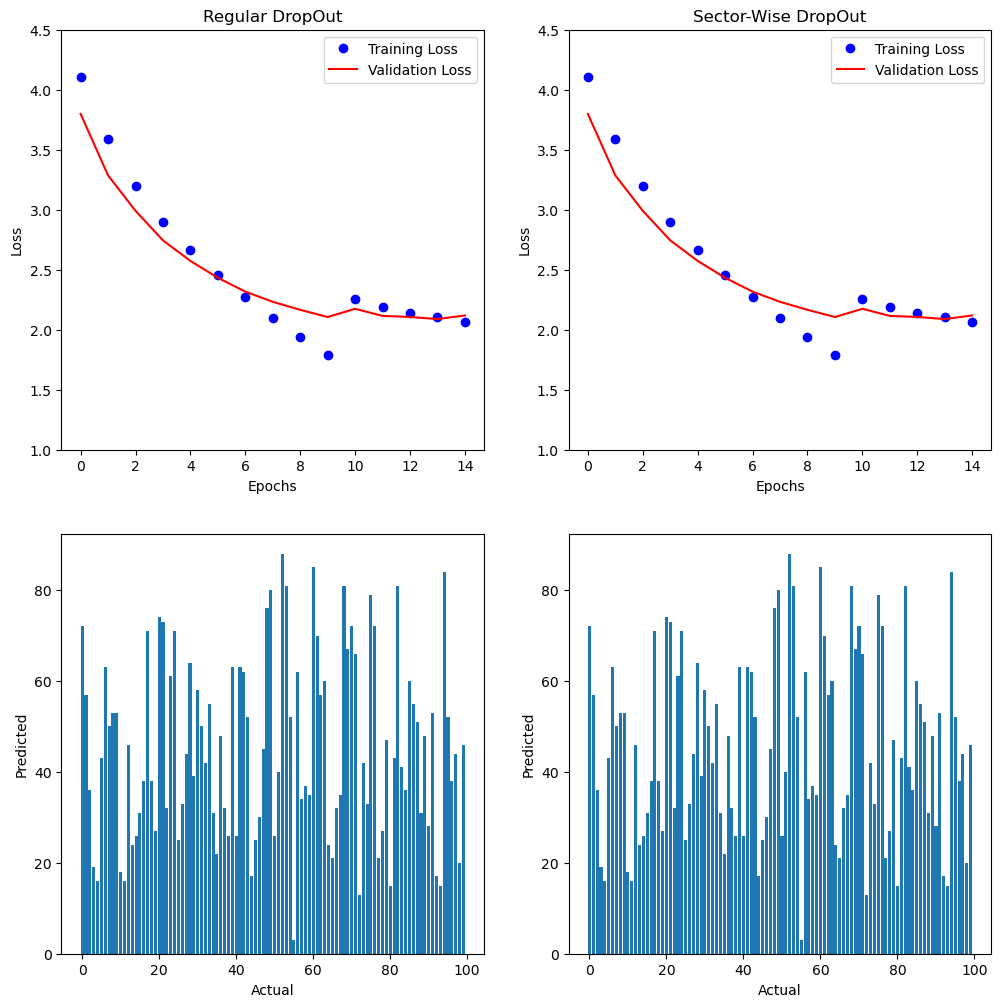

In [55]:
makeGraphs_2(sw_t_loss,sw_v_loss,sw_correct_class_totals,sw_t_loss,sw_v_loss,sw_correct_class_totals, epochs)

In [36]:
#STANDARD DROPOUT MODEL
do_model = Net(dropout_rate=dropout_rate)

do_t_loss,do_v_loss,do_tst_loss,do_correct_class_totals = train_and_test_dropout(do_model,train_loader,valid_loader,test_loader,epochs,'do-model-cifar.pt')

0
duration:  153.22517681121826
1
duration:  154.50904726982117
2
duration:  152.79243516921997
3
duration:  154.91062331199646
4
duration:  154.34170794487
5
duration:  153.21837830543518
6
duration:  155.86554670333862
7
duration:  154.88019061088562
8
duration:  157.46741271018982
9
duration:  155.03559803962708
10
duration:  157.23122763633728
11
duration:  156.1624035835266
12
duration:  155.01749515533447
13
duration:  156.3139579296112
14
duration:  154.43522024154663
15
duration:  157.61369037628174
16
duration:  154.96163082122803
17
duration:  155.71919894218445
18
duration:  154.98354768753052
19
duration:  153.7066068649292
20
duration:  155.41277956962585
21
duration:  154.38517117500305
22
duration:  155.67795133590698
23
duration:  155.51643800735474
24
duration:  154.50724291801453
25
duration:  155.920912027359
26
duration:  154.17705750465393
27
duration:  154.77771925926208
28
duration:  154.72442317008972
29
duration:  152.38994550704956
30
duration:  155.6641981601

ValueError: x and y must have same first dimension, but have shapes (15,) and (150,)

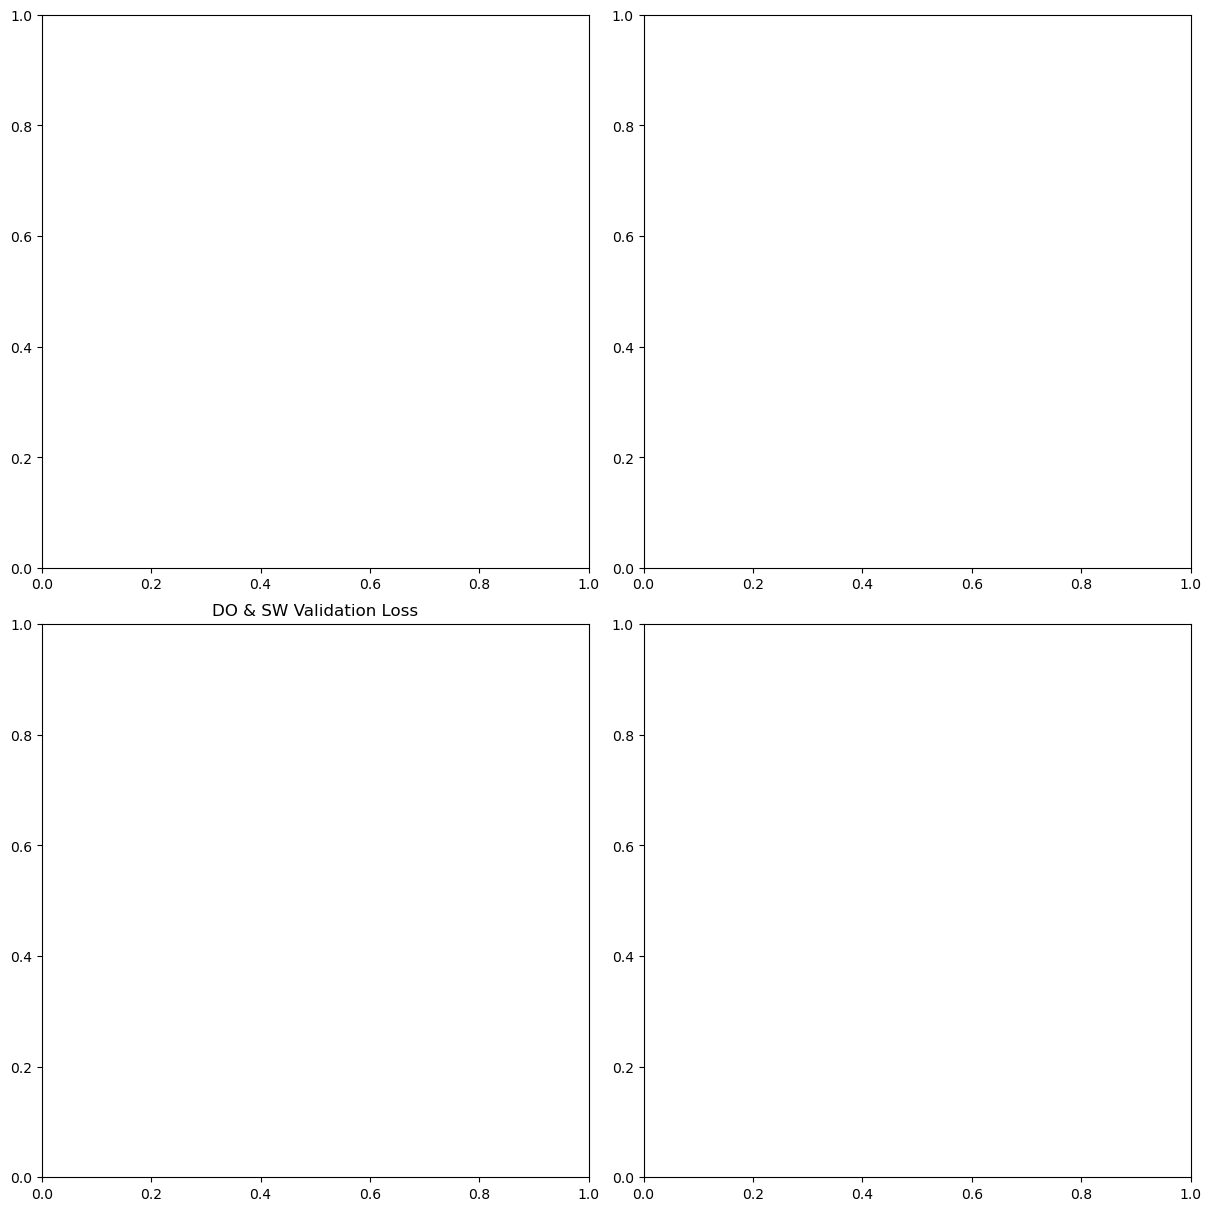

In [56]:
#50% dropout
overlayGraphs(do_t_loss,do_v_loss,do_correct_class_totals,sw_t_loss,sw_v_loss,sw_correct_class_totals, epochs)

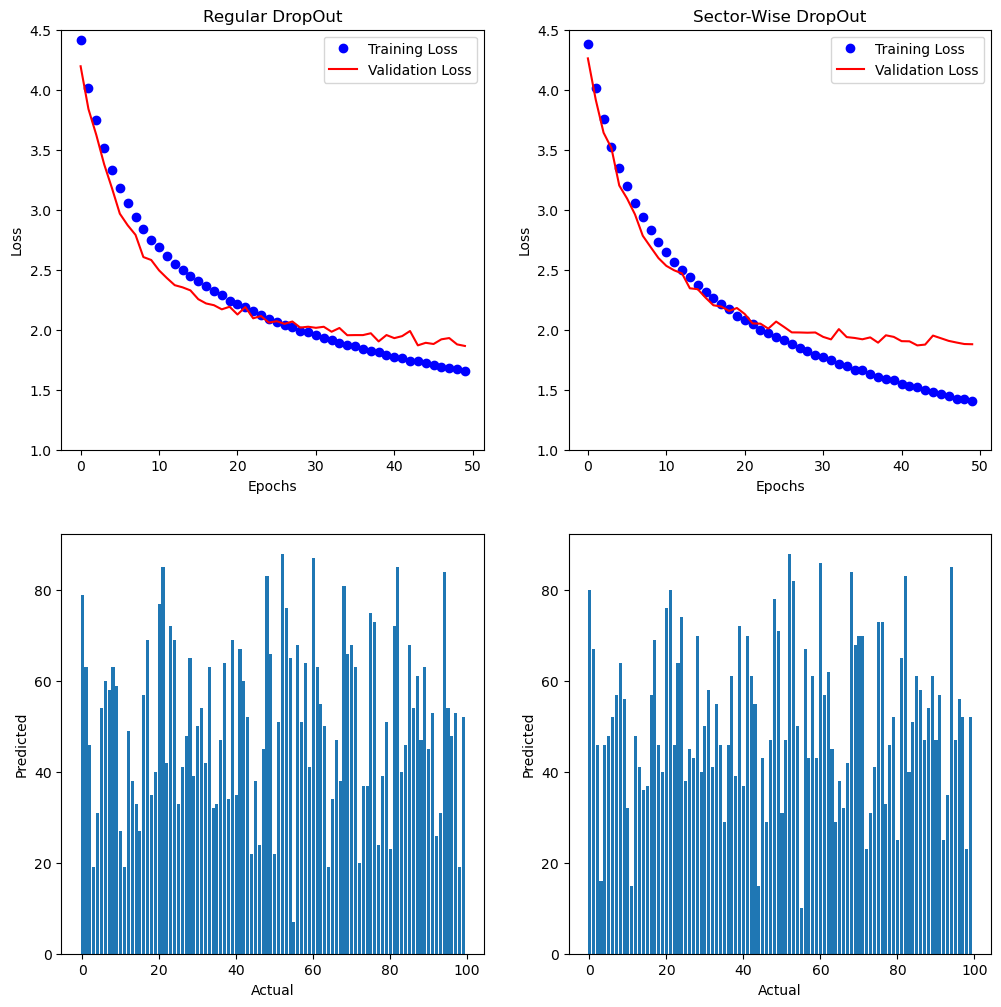

In [18]:

makeGraphs_2(do_t_loss,do_v_loss,do_correct_class_totals,sw_t_loss,sw_v_loss,sw_correct_class_totals, epochs)

In [96]:
print(sw_tst_loss)
print(do_tst_loss)

0.058356590640544895
0.058612915086746216
